In [1]:
# For Data

from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient, StockHistoricalDataClient

#from Data.historical_data import Historical_data
import pandas as pd
from Preprocessing.preprocessing import preprocessing_improved
from Models.LSTM.lightningLSTM import LightningLSTM
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from Preprocessing.dataclasses import StockPriceDataModule, StockDataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, StochasticWeightAveraging
import matplotlib.pyplot as plt
import numpy as np 

from Evaluation import evaluation_plots

In [2]:
trained_model = LightningLSTM.load_from_checkpoint("checkpoints\\best_checkpoint.ckpt",input_size=8, hidden_size = 100, num_layers = 1)
trained_model.freeze()

df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')
data_train, data_test, scaler = preprocessing_improved(df = df[:int(len(df)*0.4)], lag = 1, sequence_length=100, dif_all=True, train_size=0.9 )

test = StockDataset(data_test)

predictions = []
labels = []

for item in test:
  sequence = item["sequence"]
  label = item['label']

  _, output = trained_model(sequence.unsqueeze(dim=0))
  predictions.append(float(output.numpy()[0]))
  labels.append(float(label.numpy()))

C:\Users\lukas\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.2, which is newer than your current Lightning version: v1.9.1
  rank_zero_warn(


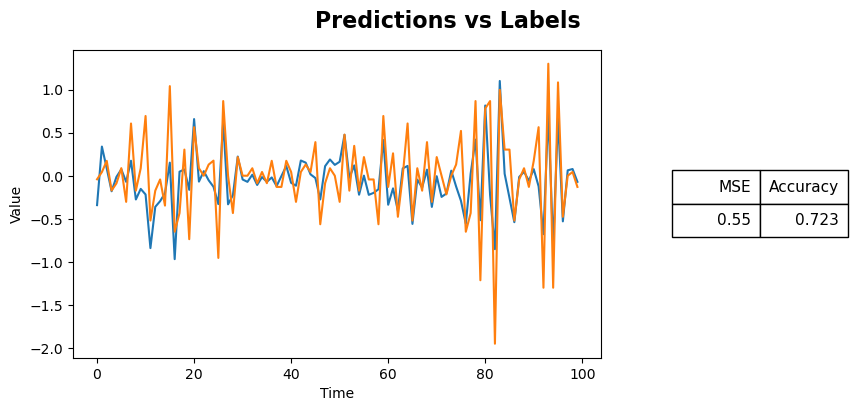

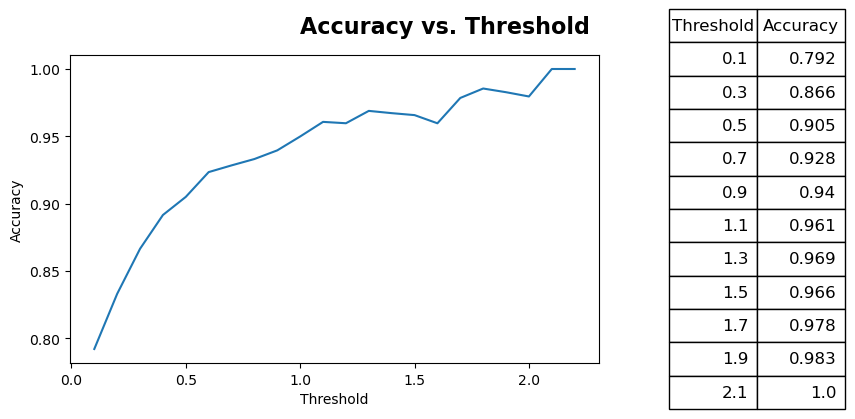

In [3]:
evaluation_plots.plot_predictions_vs_labels(predictions, labels)
evaluation_plots.plot_accuracy_vs_threshold(predictions, labels, increments=0.1, threshold_value=2.2)

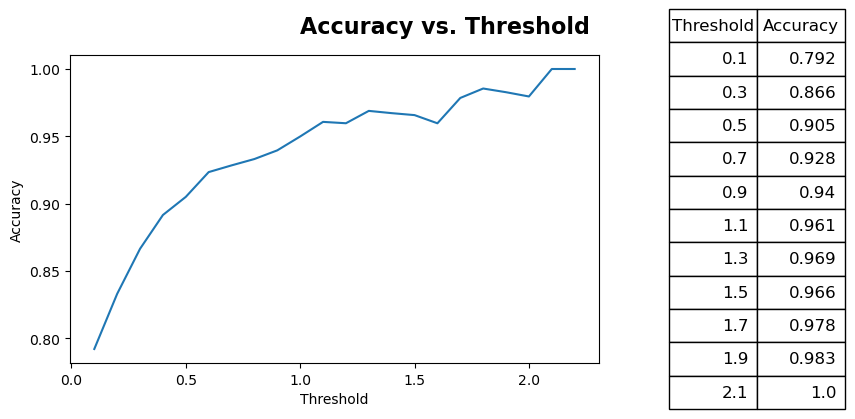

In [4]:
def plot_accuracy_vs_threshold(predictions, labels, increments = 0.1, threshold_value = 2.2):

    predictions = np.array(predictions)
    labels = np.array(labels)

    # Define the range of thresholds to test
    thresholds = np.round(np.arange(increments, threshold_value + increments, increments),1)

    # Initialize a list to store the accuracy values for each threshold
    accuracy_list = []

    # Loop over the range of thresholds and calculate the accuracy for each
    for threshold in thresholds:

        keep_indices = np.where(np.logical_or(predictions > threshold, predictions < -threshold))[0]

        new_predictions  = predictions[keep_indices]
        new_labels = labels[keep_indices]

        count = np.count_nonzero(np.array(new_predictions) * np.array(new_labels) > 0)
        
        if count == 0: 
            accuracy = 0 
        else: 
            accuracy = count / len(new_labels)

        accuracy_list.append(accuracy)


    # Create a grid of subplots
    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(1, 2, width_ratios=[3, 1])

    # Set the title above both the table and the plot
    fig.suptitle('Accuracy vs. Threshold', fontsize=16, fontweight='bold')

    # Plot the accuracy values as a line
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(thresholds[:len(accuracy_list)], accuracy_list)
    ax0.set_xlabel('Threshold')
    ax0.set_ylabel('Accuracy')

    # Display the accuracy values as a table
    data = {'Threshold': thresholds[:len(accuracy_list)], 'Accuracy': np.round(accuracy_list, 3)}
    df = pd.DataFrame(data)
    n = 10
    step = len(accuracy_list) // n
    df_sampled = df.iloc[::step, :]
    ax1 = fig.add_subplot(gs[1])
    table = ax1.table(cellText=df_sampled.values, colLabels=df_sampled.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    ax1.axis('off')

    plt.show()

evaluation_plots.plot_accuracy_vs_threshold(predictions, labels, increments=0.1, threshold_value=2.2)

In [5]:

from sklearn.preprocessing import RobustScaler

# Reshape the arrays to have shape (n_samples, 1)
predictions_reshaped = np.array(predictions).reshape(-1, 1)
labels_reshaped = np.array(labels).reshape(-1, 1)

# Extract the first column of the scaling factor for the feature of interest
scaling_factor = scaler.scale_[-1]

# Inverse transform the scaled output feature to get the original scale
predictions_descaled = predictions_reshaped * scaling_factor + scaler.center_[0]
labels_descaled = labels_reshaped * scaling_factor + scaler.center_[0]


In [6]:
predictions_descaled

array([[ 0.04036955],
       [-0.42557623],
       [ 0.2737341 ],
       ...,
       [ 0.01441593],
       [ 0.01795429],
       [-0.01631393]])

In [7]:
labels_descaled

array([[ 0.45019999],
       [-0.89010001],
       [ 0.04      ],
       ...,
       [ 0.        ],
       [ 0.01      ],
       [-0.03      ]])

In [8]:
lag = 1

# Reverse the stationary transformation by adding lagged close prices
predictions_reversed =  df['close'].shift(lag)[-len(predictions_descaled):].reset_index(drop=True)
labels_reversed =  df['close'].shift(lag)[-len(labels_descaled):].reset_index(drop=True)

In [9]:
predictions_reversed

0       286.8900
1       286.9369
2       286.8800
3       286.9100
4       286.8900
          ...   
6141    296.5100
6142    296.5600
6143    296.6000
6144    296.5300
6145    296.5300
Name: close, Length: 6146, dtype: float64

In [10]:
labels_reversed

0       286.8900
1       286.9369
2       286.8800
3       286.9100
4       286.8900
          ...   
6141    296.5100
6142    296.5600
6143    296.6000
6144    296.5300
6145    296.5300
Name: close, Length: 6146, dtype: float64

In [11]:
labels

[1.95187509059906,
 -3.8590939044952393,
 0.1734229326248169,
 -0.043355733156204224,
 0.3845653533935547,
 2.196401357650757,
 -0.6689789891242981,
 0.14740949869155884,
 -0.4123130142688751,
 0.4604378938674927,
 0.6629091501235962,
 -1.7515716552734375,
 -0.08324301242828369,
 0.860177755355835,
 -0.21331021189689636,
 1.430739164352417,
 -2.9265120029449463,
 1.8209408521652222,
 -0.9971818923950195,
 0.8671146631240845,
 -0.8887925148010254,
 0.8237589597702026,
 1.7559071779251099,
 -1.2139605283737183,
 -0.21677866578102112,
 -1.9076522588729858,
 1.2573162317276,
 0.5735963582992554,
 0.11012356728315353,
 -0.9004985690116882,
 0.47691306471824646,
 -0.13006719946861267,
 0.30349013209342957,
 0.6503360271453857,
 -0.3468458652496338,
 -1.8209408521652222,
 0.26013439893722534,
 2.2007369995117188,
 -0.10925644636154175,
 -2.525038003921509,
 1.9432040452957153,
 1.402991533279419,
 -1.828744888305664,
 0.23845653235912323,
 -1.7775850296020508,
 0.7153695821762085,
 2.35855197

In [12]:
data_test[1]

tensor([ 1.9519, -3.8591,  0.1734,  ...,  0.0000,  0.0434, -0.1301])

In [15]:
df_temp = df[:int(len(df)*0.4)]
df_temp[int(len(df_temp)*0.9)+128:]

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
56349,MSFT,2020-12-21 15:28:00+00:00,217.7376,217.8841,217.720,217.8123,39640.0,513.0,217.803491
56350,MSFT,2020-12-21 15:29:00+00:00,217.8300,217.9300,217.710,217.9000,39271.0,581.0,217.824407
56351,MSFT,2020-12-21 15:30:00+00:00,217.8300,217.9000,217.460,217.7800,65099.0,828.0,217.704927
56352,MSFT,2020-12-21 15:31:00+00:00,217.7400,217.8500,217.635,217.7700,53150.0,561.0,217.723937
56353,MSFT,2020-12-21 15:32:00+00:00,217.7700,217.7700,217.550,217.7300,59758.0,571.0,217.668086
...,...,...,...,...,...,...,...,...,...
62463,MSFT,2021-01-06 23:26:00+00:00,213.2000,213.2000,213.200,213.2000,1006.0,3.0,213.199881
62464,MSFT,2021-01-06 23:27:00+00:00,213.1900,213.1900,213.190,213.1900,143.0,8.0,213.187552
62465,MSFT,2021-01-06 23:28:00+00:00,213.1800,213.1900,213.110,213.1800,1156.0,9.0,213.169645
62466,MSFT,2021-01-06 23:29:00+00:00,213.1800,213.1800,213.180,213.1800,113.0,3.0,213.180000
